In [1]:
import mxnet as mx
import os
import multiprocessing
num_cpus = multiprocessing.cpu_count()

print("Number of CPUs:", num_cpus)

Number of CPUs: 16


In [2]:
# Global Libraries
import collections
import gluoncv as gcv
from gluoncv.utils.metrics.segmentation import SegmentationMetric
from mxnet.gluon.data.vision import transforms
from gluoncv.loss import MixSoftmaxCrossEntropyLoss
from importlib import reload
import matplotlib.pyplot as plt
from mxnet.contrib import amp
from mxnet.contrib import quantization
import numpy as np
import os
from sklearn import metrics
import time
from tqdm.notebook import tqdm

# Local Libraries
import pedestrian

## Datasets & DataLoaders

In [3]:
# Penn-Fudan Pedestrian Dataset
# https://www.cis.upenn.edu/~jshi/ped_html/
reload(pedestrian)

if not os.path.exists(pedestrian.PEDESTRIAN_FILE):
    !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

pedestrian_path = os.getcwd()

# Datasets
pedestrian_val_dataset = pedestrian.PedestrianDataset(
    pedestrian_path,
    split="val",
    is_segmentation_task=True,
    invert_masks=False)

pedestrian_test_dataset = pedestrian.PedestrianDataset(
    pedestrian_path,
    split="test",
    is_segmentation_task=True,
    invert_masks=False)

Read 25 images with 68 pedestrians
Read 25 images with 48 pedestrians


In [4]:
# Further pre-processing
# Test set pre-processing optimized for evaluation and optimizations
image_size = 480

input_transform_fn = mx.gluon.data.vision.transforms.Compose([
    mx.gluon.data.vision.transforms.Resize(image_size, keep_ratio=True),
    mx.gluon.data.vision.transforms.CenterCrop(image_size),
    mx.gluon.data.vision.transforms.ToTensor(),
    mx.gluon.data.vision.transforms.Normalize([.485, .456, .406], [.229, .224, .225])
])

to_gpu_fn = lambda x: x.as_in_context(mx.gpu())
to_cpu_fn = lambda x: x.as_in_context(mx.cpu())

input_transform_fn_gpu_cpu = mx.gluon.data.vision.transforms.Compose([
    to_gpu_fn,
    input_transform_fn,
    to_cpu_fn
])

output_transform_fn = transforms.Compose([
    transforms.Resize(image_size, keep_ratio=True),
    transforms.CenterCrop(image_size)
])

output_transform_fn_gpu_cpu = mx.gluon.data.vision.transforms.Compose([
    to_gpu_fn,
    output_transform_fn,
    to_cpu_fn
])

train_val_transform = lambda data, output: (input_transform_fn_gpu_cpu(data), output_transform_fn_gpu_cpu(output))
test_transform = lambda data, output: (input_transform_fn_gpu_cpu(data), mx.nd.moveaxis(output_transform_fn_gpu_cpu(output), -1, 0))

In [5]:
p_val  = pedestrian_val_dataset.transform(train_val_transform, lazy=False)
p_test = pedestrian_test_dataset.transform(test_transform, lazy=False)

[17:35:41] /work/mxnet/src/base.cc:79: cuDNN lib mismatch: linked-against version 8600 != compiled-against version 8204.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


In [6]:
# Single sample for forward pass (AMP & Quantization requirement)
original_shape    = p_val[0][0].shape[1:]
single_sample_cpu = p_val[0][0].reshape((1, 3) + original_shape)
single_sample_gpu = p_val[0][0].reshape((1, 3) + original_shape).as_in_context(mx.gpu())

In [7]:
# Image, GT Example for Qualitative Evaluation
test_image, test_gt_mask = pedestrian_test_dataset[24]
transformed_test_image = input_transform_fn(test_image)
test_image = output_transform_fn(test_image)
test_gt_mask = mx.nd.moveaxis(output_transform_fn(test_gt_mask), -1, 0)

## Naive CPU Inference

### Model

In [8]:
ctx = mx.cpu()
deeplab_pt_cpu = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=ctx)

#### Quantitative Evaluation: mean IoU & Pixel Accuracy

In [9]:
# Quantitative Evaluation
segmentation_metrics = SegmentationMetric(nclass=2)

start_time = time.time()

for (X, y) in tqdm(p_test):
    
    # Format inputs
    transformed_image = X.expand_dims(axis=0)
    gt_mask = y
    
    output = deeplab_pt_cpu(transformed_image)
    
    segmentation_metrics.update(gt_mask * pedestrian.COCO_PERSON_CLASS, output[0])

mx.nd.waitall()
print("Time (s):", time.time() - start_time)

metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

  0%|          | 0/25 [00:00<?, ?it/s]

Time (s): 21.008262395858765
PixAcc:  0.9602144097222223
mIoU  :  0.4742364603465315


#### Qualitative Evaluation: Image Segmentation Example + Profiling

In [10]:
mx.profiler.set_config(
    profile_all=True,
    aggregate_stats=True,
    continuous_dump=True,
    filename='profile_deeplab_cpu.json')

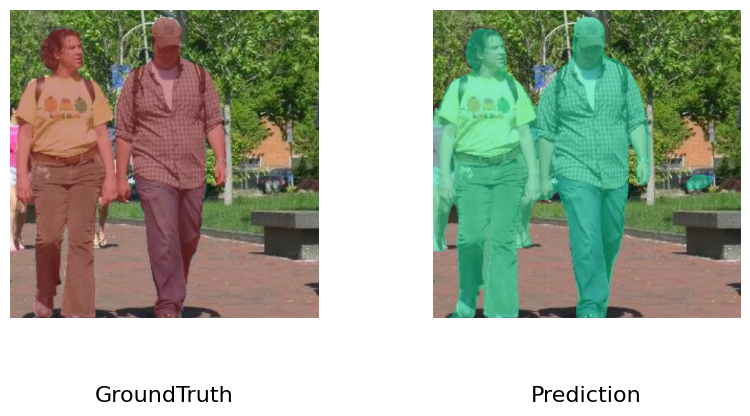

In [12]:
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)

# Profiler start
mx.profiler.set_state('run')

# Run inference while profiling
output = deeplab_pt_cpu(transformed_image)

# Wait until all operations have completed
mx.nd.waitall()
# Stop recording
mx.profiler.set_state('stop')
# Log results
mx.profiler.dump()

filtered_output = mx.nd.argmax(output[0], 1)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

## Optimal CPU Inference - INT8 Quantization + Hybridation with MKLDNN and static ops

### Calibration Dataset

In [8]:
# Dataset Loading & Transforming
# Limit to 10 samples (last ones)
max_samples = 10
samples = range(0, max_samples)

p_cal_cpu_pre = mx.gluon.data.SimpleDataset([(pedestrian_val_dataset[-i][0], pedestrian_val_dataset[-i][1]) for i in tqdm(samples)])
p_cal_gpu_cpu = p_cal_cpu_pre.transform_first(input_transform_fn_gpu_cpu, lazy=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
# DataLoader for Calibration
# For CPU, Pre-processed in GPU, copied back to CPU memory space)
num_workers = 0
batch_size = 4

p_cal_loader_gpu_cpu = mx.gluon.data.DataLoader(
    p_cal_gpu_cpu,
    batch_size=batch_size,
    num_workers=num_workers,
    last_batch="discard")

### Model

In [10]:
ctx = mx.cpu()
deeplab_pt_cpu = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=ctx)
deeplab_pt_cpu(single_sample_cpu);

In [11]:
# Log Quantization info
import logging
logging.basicConfig()
logger = logging.getLogger('logger')
logger.setLevel(logging.INFO)

In [12]:
deeplab_pt_cpu_q_hybrid = quantization.quantize_net_v2(
    deeplab_pt_cpu,
    quantized_dtype='auto',
    exclude_layers=None,
    exclude_layers_match=None,
    calib_data=p_cal_loader_gpu_cpu,
    calib_mode='entropy',
    logger=logger,
    ctx=mx.cpu())

deeplab_pt_cpu_q_hybrid.hybridize(backend="MKLDNN", static_alloc=True, static_shape=True)

INFO:logger:Export HybridBlock
INFO:logger:These layers have been excluded []
INFO:logger:Quantizing graph
[17:32:43] /work/mxnet/src/operator/quantization/quantize_graph_pass.cc:302: sg_mkldnn_conv_bn_act_0 is quantized.
[17:32:43] /work/mxnet/src/operator/quantization/quantize_graph_pass.cc:302: sg_mkldnn_conv_bn_act_1 is quantized.
[17:32:43] /work/mxnet/src/operator/quantization/quantize_graph_pass.cc:302: sg_mkldnn_conv_bn_act_2 is quantized.
[17:32:43] /work/mxnet/src/operator/quantization/quantize_graph_pass.cc:302: deeplabv30_resnetv1s_pool0_fwd is quantized.
[17:32:43] /work/mxnet/src/operator/quantization/quantize_graph_pass.cc:302: sg_mkldnn_conv_bn_act_3 is quantized.
[17:32:43] /work/mxnet/src/operator/quantization/quantize_graph_pass.cc:302: sg_mkldnn_conv_bn_act_4 is quantized.
[17:32:43] /work/mxnet/src/operator/quantization/quantize_graph_pass.cc:302: sg_mkldnn_conv_bn_6 is quantized.
[17:32:43] /work/mxnet/src/operator/quantization/quantize_graph_pass.cc:302: sg_mkldn

#### Quantitative Evaluation: mean IoU & Pixel Accuracy

In [14]:
# Quantitative Evaluation
segmentation_metrics = SegmentationMetric(nclass=2)

start_time = time.time()

for (X, y) in tqdm(p_test):
    
    # Format inputs
    transformed_image = X.expand_dims(axis=0)
    gt_mask = y
    
    output = deeplab_pt_cpu_q_hybrid(transformed_image)
    
    segmentation_metrics.update(gt_mask * pedestrian.COCO_PERSON_CLASS, output[0])

mx.nd.waitall()
print("Time (s):", time.time() - start_time)

metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

  0%|          | 0/25 [00:00<?, ?it/s]

Time (s): 10.170984745025635
PixAcc:  0.9595597222222222
mIoU  :  0.47379941937958425


#### Qualitative Evaluation: Image Segmentation Example + Profiling

In [15]:
mx.profiler.set_config(
    profile_all=True,
    aggregate_stats=True,
    continuous_dump=True,
    filename='profile_deeplab_cpu_q_hybrid.json')

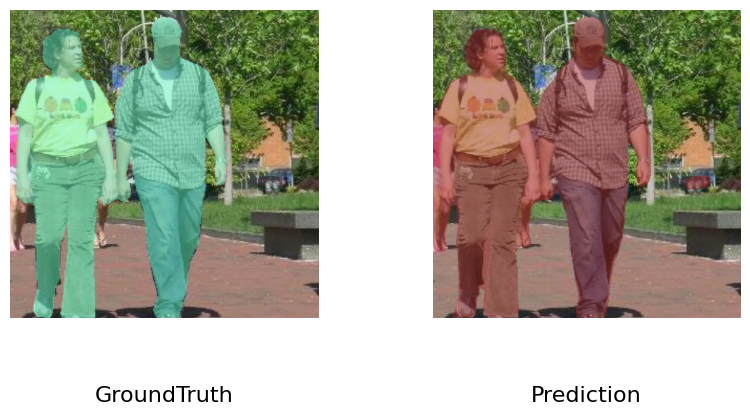

In [16]:
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)

# Profiler start
mx.profiler.set_state('run')

# Run inference while profiling
output = deeplab_pt_cpu_q_hybrid(transformed_image)

# Wait until all operations have completed
mx.nd.waitall()
# Stop recording
mx.profiler.set_state('stop')
# Log results
mx.profiler.dump()

filtered_output = mx.nd.argmax(output[0], 1)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

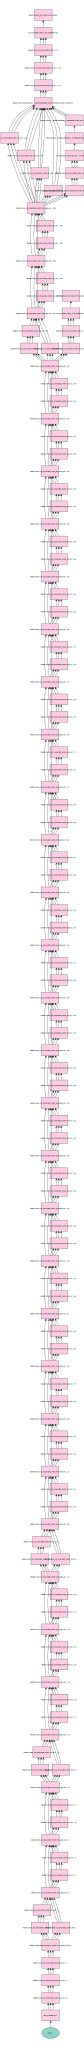

In [17]:
deeplab_pt_cpu_q_hybrid.export('deeplab_pt_cpu_q_hybrid_sym')
sym, arg_params, aux_params = mx.model.load_checkpoint('deeplab_pt_cpu_q_hybrid_sym', 0)
mx.visualization.plot_network(sym)

## Naive GPU Inference

### Model

In [8]:
ctx = mx.gpu()
deeplab_pt_gpu = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=ctx)

#### Quantitative Evaluation: mean IoU & Pixel Accuracy

In [9]:
# Quantitative Evaluation
segmentation_metrics = SegmentationMetric(nclass=2)

start_time = time.time()

for (X, y) in tqdm(p_test):
    
    # Format inputs
    transformed_image = X.expand_dims(axis=0).as_in_context(ctx)
    gt_mask = y.as_in_context(ctx)
    
    output = deeplab_pt_gpu(transformed_image)
    
    segmentation_metrics.update(gt_mask * pedestrian.COCO_PERSON_CLASS, output[0])

mx.nd.waitall()
print("Time (s):", time.time() - start_time)

metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

  0%|          | 0/25 [00:00<?, ?it/s]

[17:34:43] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


Time (s): 15.646957874298096
PixAcc:  0.9602144097222223
mIoU  :  0.4742364603465315


#### Qualitative Evaluation: Image Segmentation Example + Profiling

In [10]:
mx.profiler.set_config(
    profile_all=True,
    aggregate_stats=True,
    continuous_dump=True,
    filename='profile_deeplab_gpu.json')

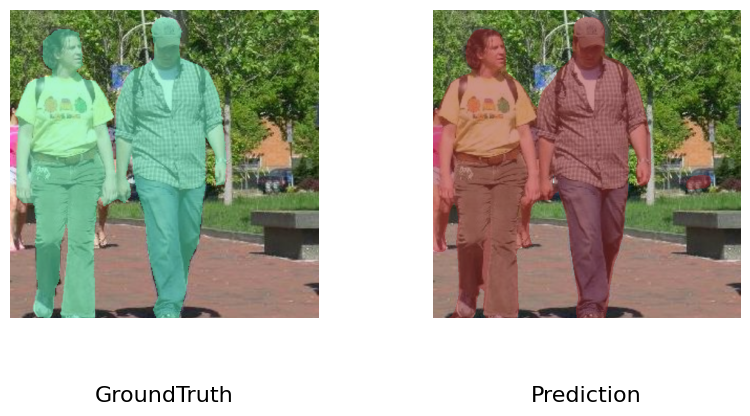

In [11]:
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)

# Profiler start
mx.profiler.set_state('run')

# Run inference while profiling
output = deeplab_pt_gpu(transformed_image)

# Wait until all operations have completed
mx.nd.waitall()
# Stop recording
mx.profiler.set_state('stop')
# Log results
mx.profiler.dump()

filtered_output = mx.nd.argmax(output[0], 1)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

## Optimal GPU Inference - Hybridation with MKLDNN and static ops + AMP

### Model

In [8]:
ctx = mx.gpu()
deeplab_pt_gpu_hybrid = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=mx.gpu())
deeplab_pt_gpu_hybrid.hybridize(static_alloc=True, static_shape=True)
deeplab_pt_gpu_hybrid(single_sample_gpu);

In [9]:
deeplab_pt_gpu_hybrid_amp = amp.convert_hybrid_block(deeplab_pt_gpu_hybrid, ctx=mx.gpu())

[17:35:47] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
/home/sa_109024352321806746181/anaconda3/envs/mxnet/lib/python3.8/site-packages/mxnet/gluon/block.py:1784: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


#### Quantitative Evaluation: mean IoU & Pixel Accuracy

In [10]:
# Quantitative Evaluation
segmentation_metrics = SegmentationMetric(nclass=2)

start_time = time.time()

for (X, y) in tqdm(p_test):
    
    # Format inputs
    transformed_image = X.expand_dims(axis=0).as_in_context(ctx)
    gt_mask = y.as_in_context(ctx)
    
    output = deeplab_pt_gpu_hybrid_amp(transformed_image)
    
    segmentation_metrics.update(gt_mask * pedestrian.COCO_PERSON_CLASS, output[0])

mx.nd.waitall()
print("Time (s):", time.time() - start_time)

metrics = segmentation_metrics.get()
print("PixAcc: ", metrics[0])
print("mIoU  : ", metrics[1])

  0%|          | 0/25 [00:00<?, ?it/s]

[17:35:59] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


Time (s): 21.19088578224182
PixAcc:  0.9602541666666666
mIoU  :  0.4742624936927797


#### Qualitative Evaluation: Image Segmentation Example + Profiling

In [11]:
mx.profiler.set_config(
    profile_all=True,
    aggregate_stats=True,
    continuous_dump=True,
    filename='profile_deeplab_gpu_hybrid_amp.json')

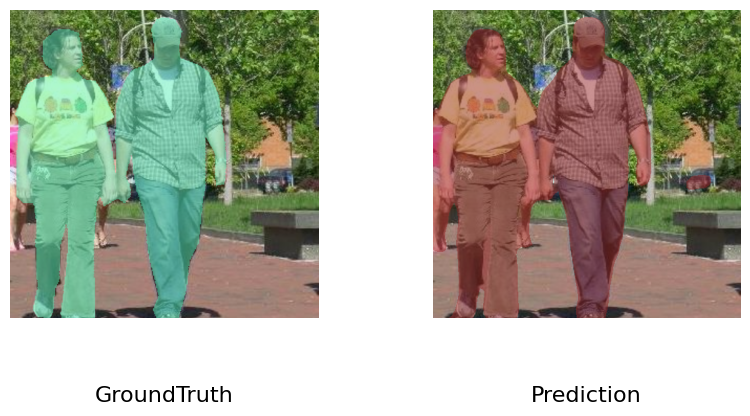

In [12]:
masked_test_image = gcv.utils.viz.plot_mask(test_image, test_gt_mask)

# Plot GroundTruth
fig = plt.figure(figsize=(10, 4))
axes = fig.add_subplot(1, 2, 1)
axes.set_title("GroundTruth", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_test_image)

# Compute and plot prediction
transformed_image = gcv.data.transforms.presets.segmentation.test_transform(test_image, ctx)

# Profiler start
mx.profiler.set_state('run')

# Run inference while profiling
output = deeplab_pt_gpu_hybrid_amp(transformed_image)

# Wait until all operations have completed
mx.nd.waitall()
# Stop recording
mx.profiler.set_state('stop')
# Log results
mx.profiler.dump()

filtered_output = mx.nd.argmax(output[0], 1)
masked_output = gcv.utils.viz.plot_mask(test_image, filtered_output)
axes = fig.add_subplot(1, 2, 2)
axes.set_title("Prediction", fontsize=16, y=-0.3)
axes.axis('off')
axes.imshow(masked_output);

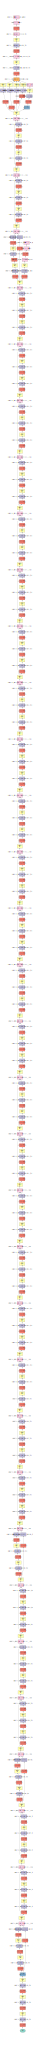

In [13]:
deeplab_pt_gpu_hybrid_amp.export('deeplab_pt_gpu_hybrid_amp_sym')
sym, arg_params, aux_params = mx.model.load_checkpoint('deeplab_pt_gpu_hybrid_amp_sym', 0)
mx.visualization.plot_network(sym)

## ONNX Export

In [78]:
# ONNX library must be installed for this
# !python3 -m pip install onnx
onnx_file_name = "deeplab_resnet101_coco_pt_gpu_hybrid.onnx"

In [79]:
deeplab_pt_gpu_hybrid = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=mx.gpu())
deeplab_pt_gpu_hybrid.hybridize(static_alloc=True, static_shape=True)
deeplab_pt_gpu_hybrid(single_sample_gpu)

# Need to be exported externally for the symbols to be loaded
deeplab_pt_gpu_hybrid_filename = "deeplab_resnet101_coco_pt_gpu_hybrid"
deeplab_pt_gpu_hybrid.export(deeplab_pt_gpu_hybrid_filename)

# Files exported
sym_filename = deeplab_pt_gpu_hybrid_filename + "-symbol.json"
params_filename = deeplab_pt_gpu_hybrid_filename + "-0000.params"

# Verify generated files
assert os.path.exists(sym_filename)
assert os.path.exists(params_filename)

In [80]:
in_shapes = [single_sample_gpu.shape]
in_types = [mx.np.float32]

onnx_model_path = mx.onnx.export_model(
    sym_filename,
    params_filename,
    in_shapes,
    in_types,
    onnx_file_name)

onnx_model_path

'deeplab_resnet101_coco_pt_gpu_hybrid.onnx'

In [81]:
# Model Verification
import onnx

# Load the ONNX model
onnx_model = onnx.load_model(onnx_model_path)

# Check the ONNX graph
onnx.checker.check_graph(onnx_model.graph)

## TensorRT Export

In [82]:
import tensorrt as trt

In [83]:
trt_file_name = "deeplab_resnet101_coco_pt_gpu_hybrid.trt"

In [84]:
TRT_LOGGER = trt.Logger(trt.Logger.INFO)
builder = trt.Builder(TRT_LOGGER)
config = builder.create_builder_config()

explicit_batch = 1 << (int) (trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
deeplab_pt_gpu_hybrid_trt = builder.create_network(explicit_batch)

[10/21/2023-15:03:59] [TRT] [I] [MemUsageChange] Init CUDA: CPU +292, GPU +0, now: CPU 6240, GPU 6190 (MiB)
[10/21/2023-15:04:02] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +261, GPU +74, now: CPU 6555, GPU 6264 (MiB)
[10/21/2023-15:04:02] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars


In [85]:
with open(onnx_file_name, 'rb') as model:
    with trt.OnnxParser(deeplab_pt_gpu_hybrid_trt, TRT_LOGGER) as parser:
        assert parser.parse(model.read()) == True
    deeplab_pt_gpu_hybrid_engine_serialized = builder.build_serialized_network(deeplab_pt_gpu_hybrid_trt, config=config)

[10/21/2023-15:04:11] [TRT] [W] onnx2trt_utils.cpp:377: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[10/21/2023-15:04:13] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 7025, GPU 6272 (MiB)
[10/21/2023-15:04:13] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +10, now: CPU 7025, GPU 6282 (MiB)
[10/21/2023-15:04:13] [TRT] [I] Local timing cache in use. Profiling results in this builder pass will not be stored.
[10/21/2023-15:04:50] [TRT] [E] 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
[10/21/2023-15:04:50] [TRT] [E] 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
[10/21/2023-15:04:50] [TRT] [W] Requested amount of GPU memory (17179869184 bytes) could not be allocated. There may not be enough free memory for allocation to succeed.
[10/21/2023-15:04:50] [TRT] 

In [86]:
with open(trt_file_name, 'wb') as f:
    f.write(bytearray(deeplab_pt_gpu_hybrid_engine_serialized))

In [87]:
# Check it can be read back
runtime = trt.Runtime(TRT_LOGGER)

with open(trt_file_name, 'rb') as f:
    deeplab_pt_gpu_hybrid_engine_deserialized = runtime.deserialize_cuda_engine(f.read())

[10/21/2023-15:04:52] [TRT] [I] Loaded engine size: 246 MiB
[10/21/2023-15:04:52] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +1, GPU +8, now: CPU 7286, GPU 6522 (MiB)
[10/21/2023-15:04:52] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +248, now: CPU 0, GPU 248 (MiB)


In [92]:
deeplab_pt_cpu_q_hybrid.export('deeplab_pt_cpu_q_hybrid_sym')
sym, arg_params, aux_params = mx.model.load_checkpoint('deeplab_pt_cpu_q_hybrid_sym', 0)
mx.visualization.plot_network(sym)

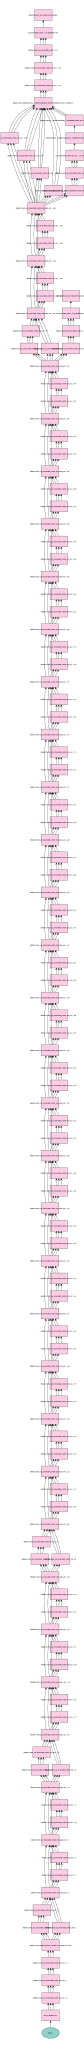